# Topic Modelling w/ LSA 
LSA применён к датасету 'A Million News Headlines' - корпусы более миллиона новостных заголовков статей ABC.

In [2]:
import numpy as np
import pandas as pd
from IPython.display import display
from tqdm import tqdm
from collections import Counter
import ast

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb

from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import scipy.stats as stats

from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

%matplotlib inline

Loading BokehJS ...

In [3]:
datafile = 'abcnews-date-text.csv'
raw_data = pd.read_csv(datafile, parse_dates=[0], infer_datetime_format=True)

reindexed_data = raw_data['headline_text']
reindexed_data.index = raw_data['publish_date']

raw_data.head()

,publish_date,headline_text
0,2003-02-19,aba decides against community broadcasting lic...
1,2003-02-19,act fire witnesses must be aware of defamation
2,2003-02-19,a g calls for infrastructure protection summit
3,2003-02-19,air nz staff in aust strike for pay rise
4,2003-02-19,air nz strike to affect australian travellers


Создаём список наиболее упоминаемых(топ-слов) на всём датасете, что позволяет понять основу словаря исходных данных. Как всегда, удаляем стоп-слова.

In [4]:
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    получаем кортеж топ n слов объекта и их сопутствующие индексы при CountV объекте и образце текста
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

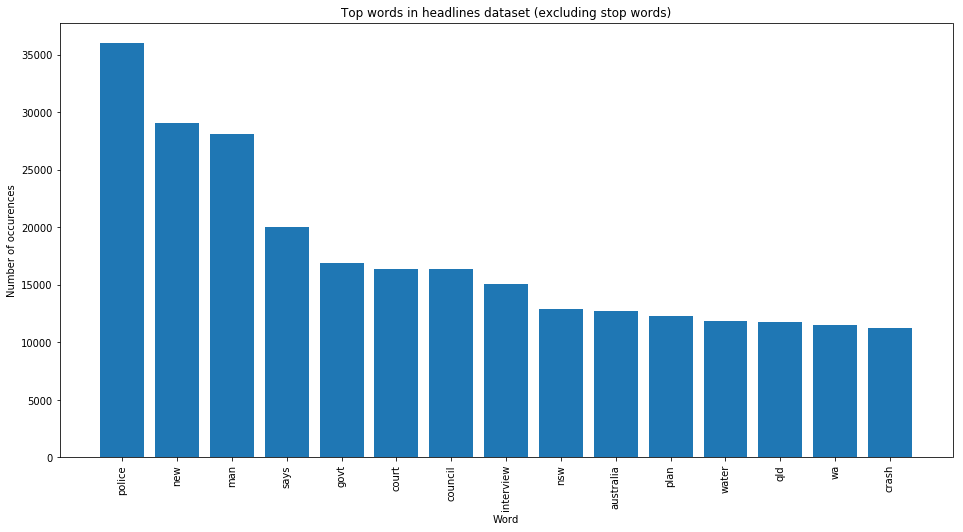

In [5]:
count_vectorizer = CountVectorizer(stop_words='english')
words, word_values = get_top_n_words(n_top_words=15,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=reindexed_data)

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in headlines dataset (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

Далее генерим гистограмму длин заголовков (в словах) и используем POS-tagging для понимания, какие типы слов используются в корпусе. Это требует конвертирования всех строк заголовков в TextBlob объекты и применение ```pos_tags```метода для каждого, выделяя список отмеченных слов для каждого заголовка. Полный список таких тегов доступен [тут](https://www.clips.uantwerpen.be/pages/MBSP-tags).

In [16]:
tagged_headlines = [TextBlob(reindexed_data[i]).pos_tags for i in range(reindexed_data.shape[0])]

In [17]:
tagged_headlines_df = pd.DataFrame({'tags':tagged_headlines})

word_counts = [] 
pos_counts = {}

for headline in tagged_headlines_df[u'tags']:
    word_counts.append(len(headline))
    for tag in headline:
        if tag[1] in pos_counts:
            pos_counts[tag[1]] += 1
        else:
            pos_counts[tag[1]] = 1
            
print('Total number of words: ', np.sum(word_counts))
print('Mean number of words per headline: ', np.mean(word_counts))

Total number of words:  7079566
Mean number of words per headline:  6.414608444787947


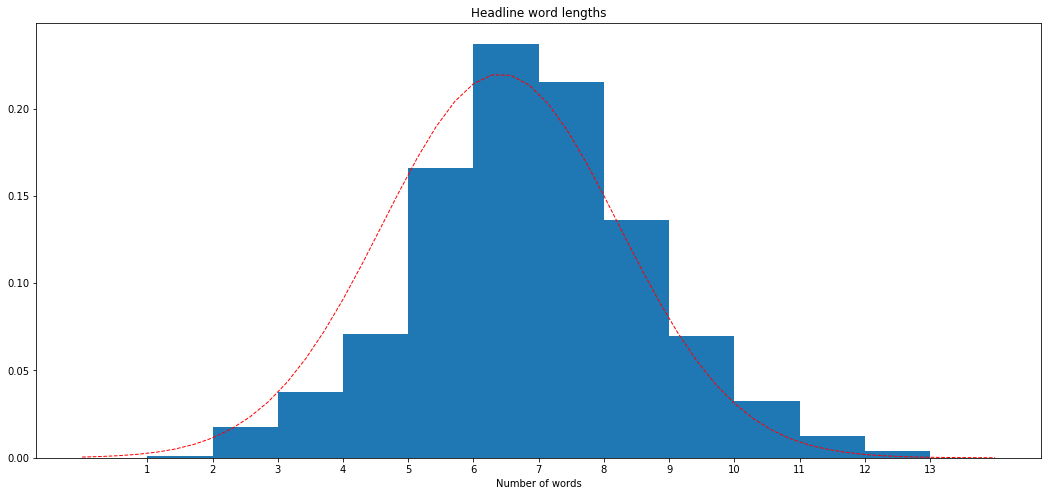

In [18]:
y = stats.norm.pdf(np.linspace(0,14,50), np.mean(word_counts), np.std(word_counts))

fig, ax = plt.subplots(figsize=(18,8))
ax.hist(word_counts, bins=range(1,14), density=True);
ax.plot(np.linspace(0,14,50), y, 'r--', linewidth=1);
ax.set_title('Headline word lengths');
ax.set_xticks(range(1,14));
ax.set_xlabel('Number of words');
plt.show()

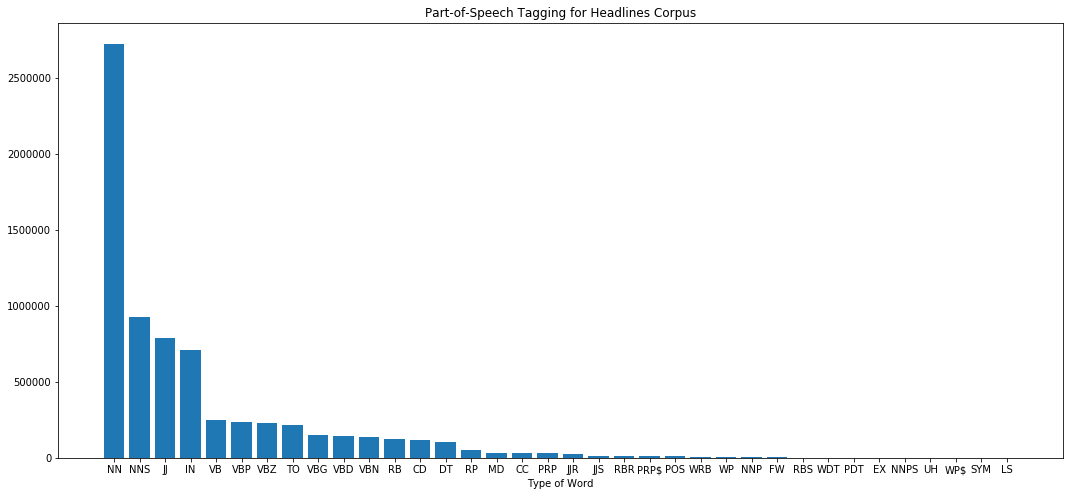

In [17]:
pos_sorted_types = sorted(pos_counts, key=pos_counts.__getitem__, reverse=True)
pos_sorted_counts = sorted(pos_counts.values(), reverse=True)

fig, ax = plt.subplots(figsize=(18,8))
ax.bar(range(len(pos_counts)), pos_sorted_counts);
ax.set_xticks(range(len(pos_counts)));
ax.set_xticklabels(pos_sorted_types);
ax.set_title('Part-of-Speech Tagging for Headlines Corpus');
ax.set_xlabel('Type of Word');

## Собственно, сам Topic Modelling

### Preprocessing
В нашем случае единственной необходимой предобработкой является построение признаков, т.е, используя CountVectorizer конвертируем каждую строку в числовой вектор, получая $n×K$ терм-документную матрицу где $K$  это кол-во различных слов на $n$ заголовках в нашей выборке

In [26]:
small_count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
small_text_sample = reindexed_data.sample(n=10000, random_state=0).values

print('Заголовок до векторизации: {}'.format(small_text_sample[123]))

small_document_term_matrix = small_count_vectorizer.fit_transform(small_text_sample)

print('После: \n{}'.format(small_document_term_matrix[123]))

Заголовок до векторизации: emerging springboks giant joins tahs
После: 
  (0, 10926)	1
  (0, 5979)	1
  (0, 4763)	1
  (0, 10457)	1
  (0, 3813)	1


Имеем наши высокоранговые и разрежённые данные в ```small_document_term_matrix```,применяем LSA. Возьмём значение параметра алгоритма кол-во топиков - 8.

In [27]:
n_topics = 8

### Latent Semantic Analysis
Экспериментируем с LSA. В общем - то, это усечённое сингулярное разложение высокоранговой и разрежённой терм-документной матрицы. с только $r=$```n_topics```  наибольшими оставшимися сингулярными значениями

In [28]:
lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(small_document_term_matrix)

Берём $\arg \max$ каждого заголовка в матрице топиков, что даст прогнозируемый топик каждого элемента в выборке. После чего сортируем это в счётчики каждого топика.

In [29]:
def get_keys(topic_matrix):
    '''
    возвращаем список прогнозов категорий топиков 
    для данной матрицы топиков
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    Кортеж категорий топиков и их соответствующие
    значения для данного списка ключей
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [30]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

В общем - то, эти категории нам ничего не дают без должного описания, найдём наиболее частые слова в них для того, чтобы характеризовать их

In [11]:
# Define helper functions
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''
    возвращает список n_topic строк, где каждая строка содержит 
    n наиболее встречающихся слов в прогнозируемой категории в порядке
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [31]:
top_n_words_lsa = get_top_n_words(10, lsa_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i+1), top_n_words_lsa[i])

Topic 1:  police crash death probe car missing drug fatal search road
Topic 2:  man charged murder jailed dies court accused guilty arrested bail
Topic 3:  new laws years open year queensland cancer abc sport centre
Topic 4:  says wa australian government qld help group school minister power
Topic 5:  court face high accused sex trial charges told faces set
Topic 6:  govt urged claims boost work act vic funds hospital closer
Topic 7:  council plan election water backs takes centre business fears national
Topic 8:  interview australia nsw world coast win day health gold cup


Конвертнули выборку в список прогнозов категорий топиков, где каждая категория представлена своими топ-словами. Относительные величины можно показать на столбцовой диаграмме.

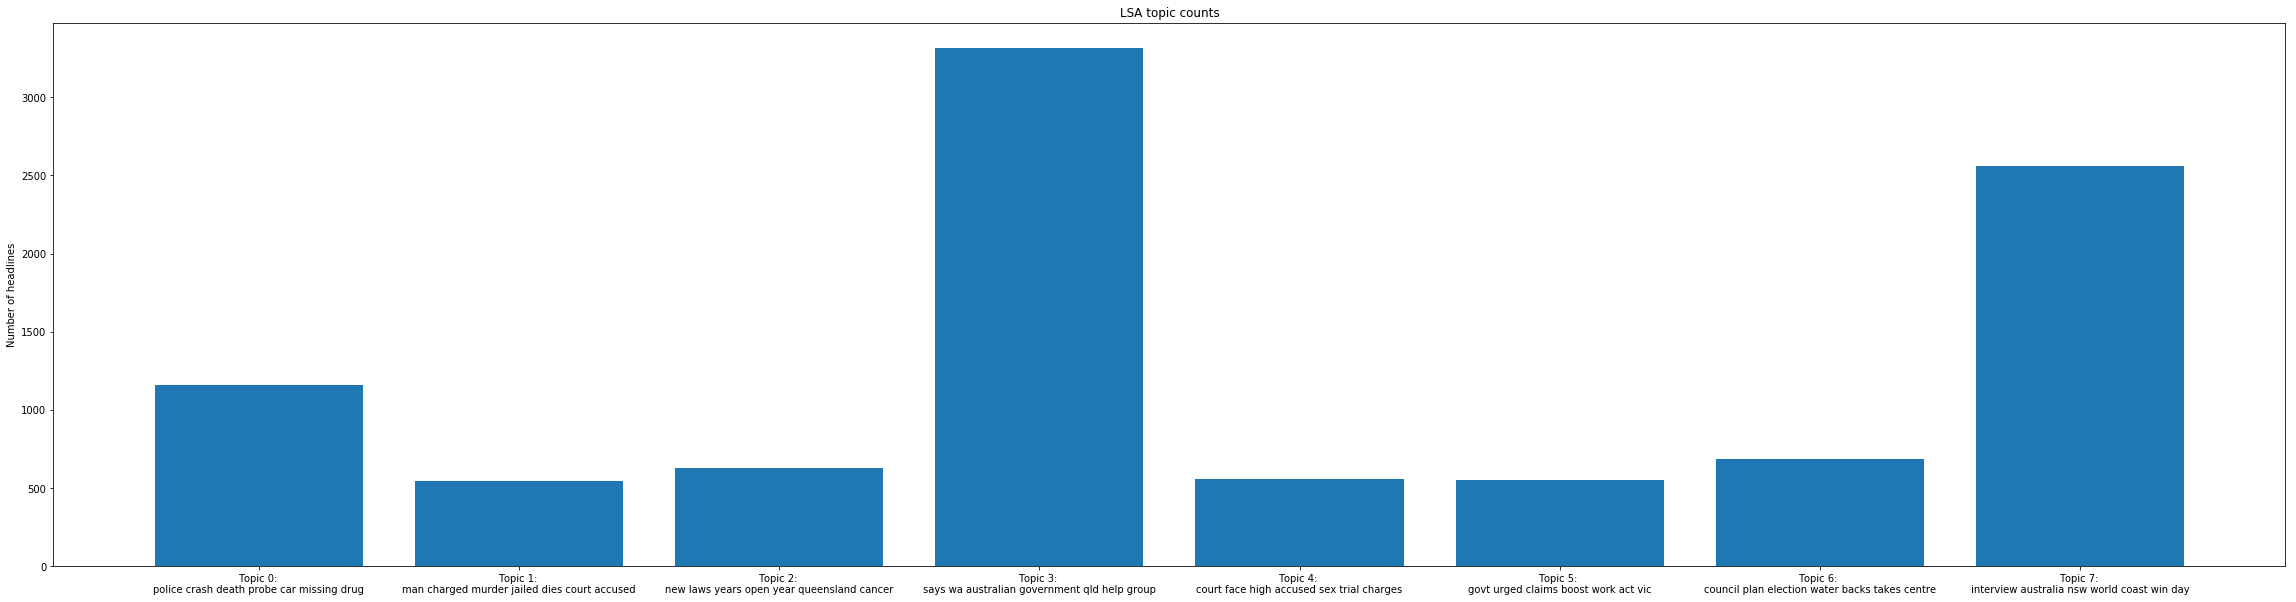

In [32]:
top_3_words = get_top_n_words(7, lsa_keys, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lsa_categories]

fig, ax = plt.subplots(figsize=(40,10))
ax.bar(lsa_categories, lsa_counts);
ax.set_xticks(lsa_categories);
ax.set_xticklabels(labels);
ax.set_ylabel('Number of headlines');
ax.set_title('LSA topic counts');
plt.show()

Далее используем $t$-SNE, метод для визуализации кластеров.

In [33]:
tsne_lsa_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=1000, verbose=10, random_state=0, angle=0.75)
tsne_lsa_vectors = tsne_lsa_model.fit_transform(lsa_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.007s...
[t-SNE] Computed neighbors for 10000 samples in 0.898s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000807
[t-SNE] Computed conditional probabilities in 1.067s
[t-SNE] Iteration 50: error = 90.6966705, gradient norm = 0.0050258 (50 iterations in 3.733s)
[t-SNE] I

Now that we have reduced these ```n_topics```-dimensional vectors to two-dimensional representations, we can then plot the clusters using Bokeh. Before doing so however, it will be useful to derive the centroid location of each topic, so as to better contextualise our visualisation.

In [14]:
# Define helper functions
def get_mean_topic_vectors(keys, two_dim_vectors):
    '''
    returns a list of centroid vectors from each predicted topic category
    '''
    mean_topic_vectors = []
    for t in range(n_topics):
        articles_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                articles_in_that_topic.append(two_dim_vectors[i])    
        
        articles_in_that_topic = np.vstack(articles_in_that_topic)
        mean_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_article_in_that_topic)
    return mean_topic_vectors

In [15]:
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:n_topics]

In [34]:
top_3_words_lsa = get_top_n_words(3, lsa_keys, small_document_term_matrix, small_count_vectorizer)
lsa_mean_topic_vectors = get_mean_topic_vectors(lsa_keys, tsne_lsa_vectors)

plot = figure(title="t-SNE Clustering of {} LSA Topics".format(n_topics), plot_width=700, plot_height=700)
plot.scatter(x=tsne_lsa_vectors[:,0], y=tsne_lsa_vectors[:,1], color=colormap[lsa_keys])

for t in range(n_topics):
    label = Label(x=lsa_mean_topic_vectors[t][0], y=lsa_mean_topic_vectors[t][1], 
                  text=top_3_words_lsa[t], text_color=colormap[t])
    plot.add_layout(label)
    
show(plot)